In [1]:
# standard libraries
import warnings

# third-party libraries
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score


# local libraries
from mfbml.methods.mf_rbf_gpr import MFRBFGPR
from mfbml.methods.rbf_kernel import RBF
from mfbml.problems.illutrative_problems import mf_Forrester
from mfbml.metrics.accuracy_metrics import (
    normalized_mae,
    normalized_rmse,
    mean_log_likelihood_value,
)

# ignore warnings
warnings.filterwarnings("ignore")

In [2]:
# fix the seed for reproducibility
seed_number = 1996
np.random.seed(seed_number)

# noise level for this case
noise_add = 0.3
noise_lf_add = 0.3

# samples information
num_hf_samples = 7
num_lf_samples = 70
num_test_samples = 1000
optimizer_restart = 10

In [3]:
func = mf_Forrester()
# define sampler
sample_lx = np.linspace(0, 1, num_lf_samples).reshape(-1, 1)
sample_hx = np.linspace(0, 1, num_hf_samples).reshape(-1, 1)
sample_x = {"hf": sample_hx, "lf": sample_lx}

# noise corruption
noise_on_train_hf_response = np.random.normal(
    0, noise_add, size=num_hf_samples
).reshape(-1, 1)
noise_on_train_lf_response = np.random.normal(
    0, noise_lf_add, size=num_lf_samples
).reshape(-1, 1)

noise_on_test_response = np.random.normal(0, noise_add, size=num_test_samples).reshape(
    -1, 1
)

# get responses for high-fidelity model
response_hf = func.hf(sample_hx) + noise_on_train_hf_response

# get responses for low-fidelity models
response_lf = func.lf_2(sample_lx) + noise_on_train_lf_response

# prepare for dict for training
sample_y = {}
# get response
sample_y["hf"] = response_hf
sample_y["lf"] = response_lf


# generate test samples
test_x = np.linspace(0, 1, num_test_samples).reshape(-1, 1)
test_hy = func.hf(test_x)
test_lf = func.lf_2(test_x)


# generate noisy test data test_x_noisy
test_x_noisy = np.linspace(0, 1, num_test_samples).reshape(-1, 1)
test_hy_noisy = func.hf(test_x_noisy) + noise_on_test_response

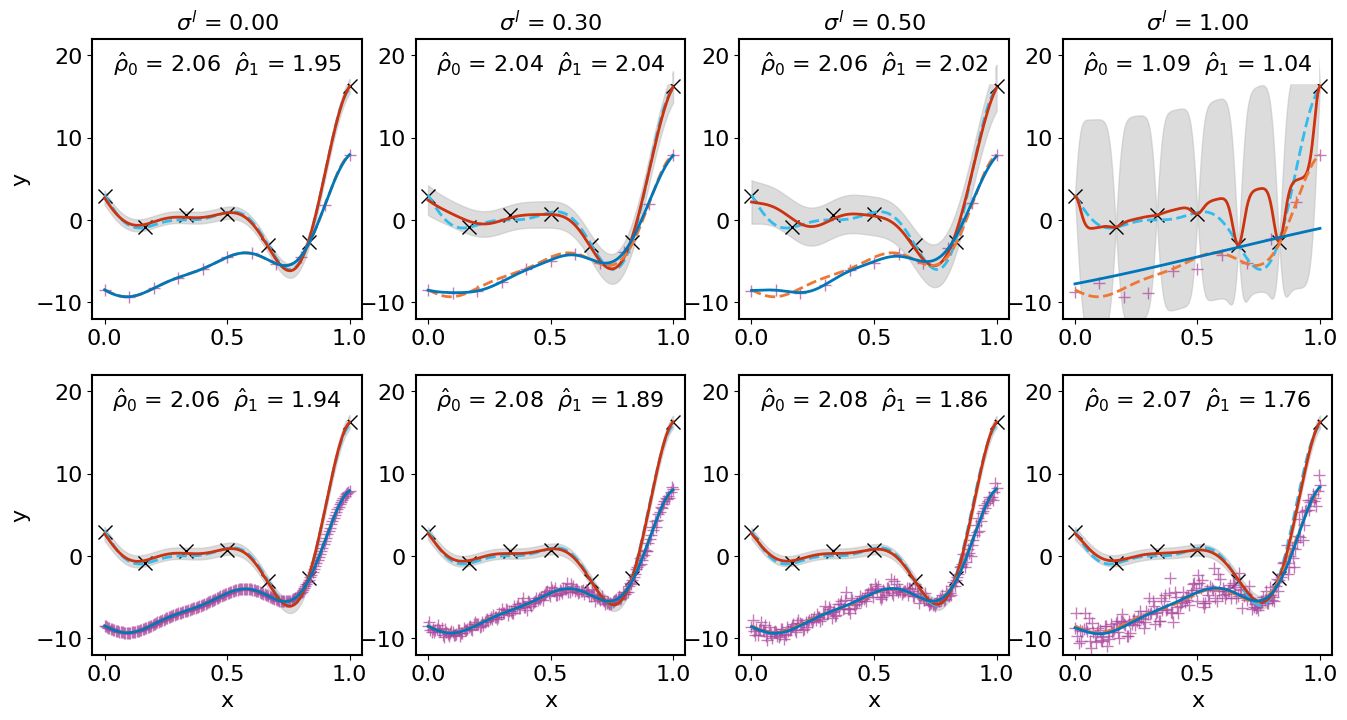

In [6]:
noise_add_lf_list = [0.0, 0.3, 0.5, 1.0]
lf_sample_number_list = [11, 200]

# define kernel
kernel = RBF(
    theta=np.ones(func.num_dim),
    bounds=[-2, 3],
)
font_size = 16

# create np array to store the results
nll_values = np.zeros((len(lf_sample_number_list), len(noise_add_lf_list)))
r2_values = np.zeros((len(lf_sample_number_list), len(noise_add_lf_list)))
nmae_values = np.zeros((len(lf_sample_number_list), len(noise_add_lf_list)))
nrmse_values = np.zeros((len(lf_sample_number_list), len(noise_add_lf_list)))
noise_estimate = np.zeros((len(lf_sample_number_list), len(noise_add_lf_list)))
# plot the figure for different noise level and different number of low-fidelity samples
fig, ax = plt.subplots(2, 4, figsize=(16, 8))
for i, lf_sample_number in enumerate(lf_sample_number_list):
    for j, noise_add_lf in enumerate(noise_add_lf_list):

        # define sampler
        sample_lx = np.linspace(0, 1, lf_sample_number).reshape(-1, 1)
        sample_x = {"hf": sample_hx, "lf": sample_lx}
        # noise corruption
        noise_on_train_lf_response = np.random.normal(
            0, noise_add_lf, size=lf_sample_number
        ).reshape(-1, 1)

        # get responses for low-fidelity models
        response_lf = func.lf_2(sample_lx) + noise_on_train_lf_response

        # prepare for dict for training
        sample_y["lf"] = response_lf

        model = MFRBFGPR(
            design_space=func.design_space,
            noise_prior=None,
            kernel=kernel,
            optimizer_restart=optimizer_restart,
            seed=seed_number,
        )
        model.train(samples=sample_x, responses=sample_y)

        pred_y, pred_std = model.predict(X=test_x, return_std=True)
        # get prediction of low fidelity
        pred_ly = model.predict_lf(X=test_x)

        # get the accuracy metrics
        nll_values[i, j] = mean_log_likelihood_value(
            test_hy_noisy, pred_y, pred_std)
        r2_values[i, j] = r2_score(test_hy, pred_y)
        nmae_values[i, j] = normalized_mae(test_hy, pred_y)
        nrmse_values[i, j] = normalized_rmse(test_hy, pred_y)
        noise_estimate[i, j] = model.noise

        # save results to csv files with
        np.savetxt(
            "nll_values.csv", nll_values, delimiter=",", header="0.0, 0.3, 0.5, 1.0"
        )
        np.savetxt(
            "r2_values.csv", r2_values, delimiter=",", header="0.0, 0.3, 0.5, 1.0"
        )
        np.savetxt(
            "nmae_values.csv", nmae_values, delimiter=",", header="0.0, 0.3, 0.5, 1.0"
        )
        np.savetxt(
            "nrmse_values.csv", nrmse_values, delimiter=",", header="0.0, 0.3, 0.5, 1.0"
        )
        np.savetxt(
            "noise_estimate.csv",
            noise_estimate,
            delimiter=",",
            header="0.0, 0.3, 0.5, 1.0",
        )

        ax[i, j].plot(
            sample_x["hf"],
            sample_y["hf"],
            "kx",
            linewidth=2,
            markersize=10,
            label="HF samples",
        )
        ax[i, j].plot(
            sample_x["lf"],
            sample_y["lf"],
            "+",
            color="#AA4499",
            linewidth=2,
            markersize=8,
            alpha=0.7,
            label="LF samples",
        )
        ax[i, j].plot(
            test_x, test_hy, "--", color="#33BBEE", linewidth=2, label="HF truth"
        )
        ax[i, j].plot(
            test_x, pred_y, "-", color="#CC3311", linewidth=2, label="HF prediction"
        )
        ax[i, j].plot(
            test_x, test_lf, "--", color="#EE7733", linewidth=2, label="LF truth"
        )
        ax[i, j].plot(
            test_x, pred_ly, "-", color="#0077BB", linewidth=2, label="LF prediction"
        )

        ax[i, j].fill_between(
            test_x.flatten(),
            (pred_y - 2 * pred_std).flatten(),
            (pred_y + 2 * pred_std).flatten(),
            alpha=0.5,
            color="#BBBBBB",
            label="CI interval",
        )
        ax[i, j].set_ylim(-12, 22)
        ax[i, j].text(
            0.5,
            19.0,
            r"$\hat \rho_0$ = {:.2f}  $\hat \rho_1$ = {:.2f}".format(
                model.beta[0, 0], model.beta[1, 0]
            ),
            fontsize=font_size,
            ha="center",
            va="center",
            backgroundcolor="white",
        )
        if i == 0:
            ax[i, j].set_title(
                r"$\sigma^l$ = {:.2f}".format(noise_add_lf), fontsize=font_size
            )
        if i == 1:
            ax[i, j].set_xlabel("x", fontsize=font_size)
        if j == 0:
            ax[i, j].set_ylabel("y", fontsize=font_size)

        ax[i, j].tick_params(axis="both", which="major", labelsize=font_size)
        # set the line width of the axis
        for axis in ["top", "bottom", "left", "right"]:
            ax[i, j].spines[axis].set_linewidth(1.5)

plt.savefig("different_noise_influence.png", dpi=300, bbox_inches="tight")
plt.savefig("different_noise_influence.pdf", dpi=300, bbox_inches="tight")
plt.savefig("different_noise_influence.svg", dpi=300, bbox_inches="tight")
plt.show()